<a href="https://colab.research.google.com/github/amyy2/thesis/blob/main/MoCo_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install torch torchvision

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import nibabel as nib
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/archive'

Mounted at /content/drive


In [ ]:
!git clone https://github.com/facebookresearch/moco.git
%cd moco

Cloning into 'moco'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 108 (delta 38), reused 60 (delta 31), pack-reused 38
Receiving objects: 100% (108/108), 65.39 KiB | 4.09 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/moco


# Data preprocessing

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.path))

    def __getitem__(self, index):
        folder = os.listdir(self.path)[index]
        folder_path = self.path + '/' + folder + '/' + folder
        image = nib.load(folder_path + '_flair.nii').get_fdata()[50:210, 50:210, 77]
        mask = nib.load(folder_path + '_seg.nii').get_fdata()[50:210, 50:210, 77]

        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.astype(np.float32)

        if self.transform:
          transform_1 = self.transform(image)
          transform_2 = self.transform(image)

          return image, transform_1, transform_2, mask

        else:
          return image, mask

In [ ]:
def calculate_mean_std(dataset):
    means = []
    stds = []

    for i in tqdm(range(len(dataset))):
        image, _ = dataset[i]
        image = image.astype(np.float32)
        means.append(np.mean(image))
        stds.append(np.std(image))

    mean = np.mean(means)
    std = np.mean(stds)
    return mean, std

dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')

#mean, std = calculate_mean_std(dataset)
mean = 0.2855491638183594
std = 0.2328324317932129
print(f'Mean: {mean}, Std: {std}')

Mean: 0.2855491638183594, Std: 0.2328324317932129


In [ ]:
simclr_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.RandomRotation(degrees=(180, 360))]),
    #transforms.RandomApply([transforms.RandomResizedCrop(size=(160, 160), scale=(0.8, 1.0), ratio=(1.0, 1.0))], p=0.25),
    transforms.RandomApply([transforms.RandomHorizontalFlip()]),
    transforms.RandomApply([transforms.RandomVerticalFlip()]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

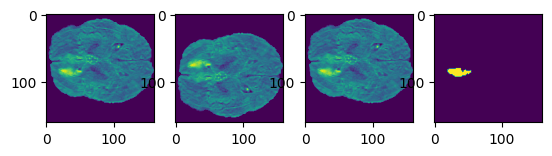

In [ ]:
dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', transform=simclr_transform)
image, t1, t2, mask = dataset[30]
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.subplot(1, 4, 2)
plt.imshow(t1[0])
plt.subplot(1, 4, 3)
plt.imshow(t2[0])
plt.subplot(1, 4, 4)
plt.imshow(mask)
plt.show()

# Pretrained MoCo model

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """

    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07, mlp=False):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the encoders
        # num_classes is the output fc dimension
        self.encoder_q = base_encoder()
        self.encoder_k = base_encoder()

        if mlp:
            # Modify the fully connected layer
            dim_mlp = self.encoder_q.fc[0].in_features  # Access the in_features of the first Linear layer
            self.encoder_q.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(),
                nn.Linear(dim_mlp, dim)  # The last layer now outputs 'dim' features
            )
            self.encoder_k.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(),
                nn.Linear(dim_mlp, dim)  # Same modification for the key encoder
            )

        for param_q, param_k in zip(
            self.encoder_q.parameters(), self.encoder_k.parameters()
        ):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(
            self.encoder_q.parameters(), self.encoder_k.parameters()
        ):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        self.queue[:, :-keys.shape[0]] = self.queue[:, keys.shape[0]:]
        self.queue[:, -keys.shape[0]:] = keys.T

    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """

        # Compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)

        # Compute key features
        with torch.no_grad():  # No gradient to keys
            self._momentum_update_key_encoder()  # Update the key encoder
            k = self.encoder_k(im_k)  # Keys: NxC
            k = nn.functional.normalize(k, dim=1)

        # Compute logits
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)  # Positive logits: Nx1
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])  # Negative logits: NxK

        logits = torch.cat([l_pos, l_neg], dim=1)  # Logits: Nx(1+K)
        logits /= self.T  # Apply temperature

        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        # Dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits, labels

In [ ]:
def base_encoder(pretrained=False, dim=128):
    model = models.resnet50(pretrained=pretrained)

    # Adjust the first convolutional layer
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Adjust the fully connected layer to match the size in the checkpoint
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, dim),
        nn.ReLU(),
        nn.Linear(dim, dim)
    )

    return model

moco = MoCo(base_encoder=base_encoder, dim=128, mlp=True)

checkpoint = torch.load('/content/drive/MyDrive/moco_v2_800ep_pretrain.pth.tar')

# Adjust the 'conv1' weights in the state_dict
conv1_weight = checkpoint['state_dict']['module.encoder_q.conv1.weight']
new_conv1_weight = conv1_weight.mean(dim=1, keepdim=True)

moco.encoder_q.conv1.weight.data = new_conv1_weight

new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}

del new_state_dict['encoder_q.conv1.weight']

moco.load_state_dict(new_state_dict, strict=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


_IncompatibleKeys(missing_keys=['queue', 'queue_ptr', 'encoder_q.conv1.weight', 'encoder_k.conv1.weight', 'encoder_k.bn1.weight', 'encoder_k.bn1.bias', 'encoder_k.bn1.running_mean', 'encoder_k.bn1.running_var', 'encoder_k.layer1.0.conv1.weight', 'encoder_k.layer1.0.bn1.weight', 'encoder_k.layer1.0.bn1.bias', 'encoder_k.layer1.0.bn1.running_mean', 'encoder_k.layer1.0.bn1.running_var', 'encoder_k.layer1.0.conv2.weight', 'encoder_k.layer1.0.bn2.weight', 'encoder_k.layer1.0.bn2.bias', 'encoder_k.layer1.0.bn2.running_mean', 'encoder_k.layer1.0.bn2.running_var', 'encoder_k.layer1.0.conv3.weight', 'encoder_k.layer1.0.bn3.weight', 'encoder_k.layer1.0.bn3.bias', 'encoder_k.layer1.0.bn3.running_mean', 'encoder_k.layer1.0.bn3.running_var', 'encoder_k.layer1.0.downsample.0.weight', 'encoder_k.layer1.0.downsample.1.weight', 'encoder_k.layer1.0.downsample.1.bias', 'encoder_k.layer1.0.downsample.1.running_mean', 'encoder_k.layer1.0.downsample.1.running_var', 'encoder_k.layer1.1.conv1.weight', 'encode

# Fine-tune model on BraTS

In [ ]:
dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', transform=simclr_transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

'\ntrain_size = int(0.8 * len(dataset))\nval_size = len(dataset) - train_size\ntrain_dataset, val_dataset = random_split(dataset, [train_size, val_size])\n\ntrain_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)\n'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = moco.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

num_epochs = 100

loss_values = []

model.train()

for epoch in tqdm(range(num_epochs)):
    for i, (image, im_q, im_k, mask) in enumerate(dataloader):

        im_q = im_q.to(device)
        im_k = im_k.to(device)

        output, target = model(im_q=im_q, im_k=im_k)

        loss = F.cross_entropy(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
          #print(f'Epoch: [{epoch}][{i}/{len(dataloader)}]\t'f'Loss {loss.item():.4f}\t')
          loss_values.append(loss.item())

torch.save(moco.state_dict(), '/content/drive/MyDrive/archive/moco_state_dict_3.pth')
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()

  0%|          | 0/100 [00:23<?, ?it/s]


KeyboardInterrupt: ignored

# Downstream task (segmentation)